VRP is one of the most studied combinatorial problems in the field of operation research since it was first published by George Dantzig and John Ramser in 1959. There are many solution approaches for VRP. Also, there are many variants of VRP like time window, split delivery, delivery and pickup, etc. In this notebook, I handled VRP with time window (VRPTW) variant with two index formulation. I used the CVRP (Capacitated VRP) formulation explained in this nice video: https://www.youtube.com/watch?v=-DjyO0DK9Ys&lc=UgxMxKN9Rf2Nt-qw8cF4AaABAg.99DQl9ZZ1b59NoECfvkBHZ. I also added some extra constraints to make the model tighter. As for time window constraints, I took them from this work: https://arxiv.org/pdf/1606.01935.pdf. I added some extra constraints for VRPTW. Firstly, I solved VRP (capacitated VRP) and then VRPTW. In this model, you can solve VRP and VRPTW up to 50 customers in a reasonable amount of time. According to randomly generated data, the model may be infeasible. In this case, you have to create another random data set by running the model again from scratch. The solution time varies considerably according to the values of the parameters generated every run. You can see other variants in this link: https://www.udemy.com/course/vehicle-routing-problem-with-spreadsheet/learn/lecture/22306076#content

In [1]:
from gurobipy import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
rnd = np.random
#rnd.seed(4)

In [4]:
#parameters
n = 50  # number of customers
xc = rnd.rand(n+1)*200
yc = rnd.rand(n+1)*100
Q = 45 #vehicle capacity
speed = 90 #average speed of a vehicle. It is needed for VRPTW
s = 0.3 #duration of service. It is needed for VRPTW
wa = [0 if i == 0  else np.random.randint(0,8) for i in range(n+1)]#the erliest service time for the cutomers, including depot
wb = [10 if i == 0 else wa[i]+np.random.randint(2,5) for i in range(n+1)]#the latest service time for the cutomers, including depot

In [5]:
#parameters and sets
N = [i for i in range(1, n+1)] #set of customers
V = [0] + N #set of customers, including depot
A = [(i, j) for i in V for j in V if i != j]
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A} ##distance between customer i and j
q = {i: rnd.randint(5, Q/3) for i in N} #amount of customer demands

In [6]:
t = {i: c[i]/speed for i in c} #traveling time between customer i and j

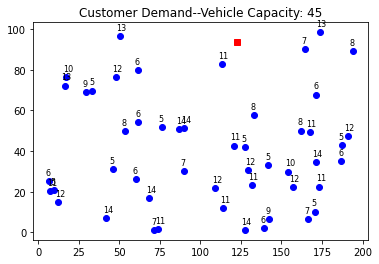

In [7]:
koordinat = np.array(list(zip(xc,yc)))
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')
for i in range(1,n+1):
    plt.text(koordinat[:,0:1][i]-2,koordinat[:,1:2][i]+3, q[i], fontsize = 8)#https://www.statology.org/matplotlib-annotate-scatterplot/
plt.title("Customer Demand--Vehicle Capacity: "+str(Q))
plt.show()

In [8]:
sum(q.values())/Q #minimum number of required vehicles. 

10.28888888888889

In [9]:
from gurobipy import Model, GRB, quicksum

In [10]:
mdl = Model('CVRP')

Using license file C:\Users\aakgul\gurobi.lic
Academic license - for non-commercial use only - expires 2021-06-23


In [11]:
x = mdl.addVars(A, vtype=GRB.BINARY, name = "x")#if a vehicle goes from customer i to customer j, it equals to 1, otherwise 0
f = mdl.addVars(A, vtype=GRB.CONTINUOUS, name = "f")#cumulatif load of a vehicle when the vehicle arrives customer j by leaving customer i. It is need for subtour elemination.
w = mdl.addVars(V, vtype=GRB.CONTINUOUS, name = "w")#start time of service at customer i

In [12]:
mdl.setObjective(quicksum(x[i, j]*c[i, j] for i, j in A)) #minimize total lenght coverd by all vehicles

In [13]:
#mdl.setObjective(quicksum(x[i, j] for i in [0] for j in N if j != i)) #minimize number of vehicles

In [14]:
mdl.addConstrs((quicksum(x[i, j] for j in N if j != i)== math.ceil(sum(q.values())/Q) for i in [0] ), name = "c0") #if we dont
#set this equation, model proposes many unnecessary vehicles to find shortest distance. We dont want such a case, you can disable
#this equation and see what will happen at the "Actual Loads vs. Capacity, Average" grapg below.

{0: <gurobi.Constr *Awaiting Model Update*>}

In [15]:
#These equations are needed for CVRP. Formulation was explained in youtube video above.
mdl.addConstrs((quicksum(x[i, j] for j in V if j != i) == 1 for i in N), name = "c1")
mdl.addConstrs((quicksum(x[i, j] for i in V if i != j) == 1 for j in N), name = "c2")

mdl.addConstrs(((quicksum(f[j, i] for j in V if j != i) - 
                quicksum(f[i,j] for j in V if j != i)) == q[i] for i in N), name = "c3")

mdl.addConstrs(((f[i, j] - x[i, j] * Q) <=0 for i,j in A), name = "c4")

{(0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 19): <gurobi.Constr *Awaiting Model Update*>,
 (0, 20): <gurobi.Constr *Awaiting Model

In [16]:
#Calculated for making the model tighther. https://arxiv.org/pdf/1606.01935.pdf 
maks = {(i,j): wb[i]-wa[j]-s for i in V for j in N if i != j}
makss = {(i,j): maks[i,j] if maks[i,j]> 0 else 0 for i,j in maks}

In [17]:
#All formulations below are related to VRPTW and were explained in this website: https://arxiv.org/pdf/1606.01935.pdf 
#A vehicle can departure customer i before earliest time of customer i, but can not departure after latest time of customer i
mdl.addConstrs((w[j]-w[i]-x[i,j]*(t[i,j]+s) + makss[i,j]*(1-x[i,j]) >= 0 for i in V for j in N if i != j ), name = "c5")

{(0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 5): <gurobi.Constr *Awaiting Model Update*>,
 (0, 6): <gurobi.Constr *Awaiting Model Update*>,
 (0, 7): <gurobi.Constr *Awaiting Model Update*>,
 (0, 8): <gurobi.Constr *Awaiting Model Update*>,
 (0, 9): <gurobi.Constr *Awaiting Model Update*>,
 (0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (0, 11): <gurobi.Constr *Awaiting Model Update*>,
 (0, 12): <gurobi.Constr *Awaiting Model Update*>,
 (0, 13): <gurobi.Constr *Awaiting Model Update*>,
 (0, 14): <gurobi.Constr *Awaiting Model Update*>,
 (0, 15): <gurobi.Constr *Awaiting Model Update*>,
 (0, 16): <gurobi.Constr *Awaiting Model Update*>,
 (0, 17): <gurobi.Constr *Awaiting Model Update*>,
 (0, 18): <gurobi.Constr *Awaiting Model Update*>,
 (0, 19): <gurobi.Constr *Awaiting Model Update*>,
 (0, 20): <gurobi.Constr *Awaiting Model

In [18]:
mdl.addConstrs((w[i] <= wb[i]-s for i in V), name = "c6")#All processes, 
#including the service period, must be completed within this time interval. I made a minor change in this formulation

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [19]:
mdl.addConstrs((w[i] >= wa[i] for i in V), name = "c7")

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [20]:
#parameter tuning for speeding up the model
mdl.Params.MIPGap = 0.05
mdl.params.Cuts = 3
mdl.params.PreSparsify = 0
mdl.params.DegenMoves = 2
mdl.params.Heuristics = 0.5
mdl.params.GomoryPasses = 1
mdl.params.Method = 0
mdl.params.MIPFocus = 3 #you can disable this tune while working on small-scale models,20-30 customers
mdl.optimize()

Changed value of parameter MIPGap to 0.05
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Changed value of parameter Cuts to 3
   Prev: -1  Min: -1  Max: 3  Default: -1
Changed value of parameter PreSparsify to 0
   Prev: -1  Min: -1  Max: 1  Default: -1
Changed value of parameter DegenMoves to 2
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter Heuristics to 0.5
   Prev: 0.05  Min: 0.0  Max: 1.0  Default: 0.05
Changed value of parameter GomoryPasses to 1
   Prev: -1  Min: -1  Max: 2000000000  Default: -1
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter MIPFocus to 3
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5303 rows, 5151 columns and 22752 nonzeros
Model fingerprint: 0x4a0c3c26
Variable types: 2601 continuous, 2550 integer (2550 binary)
Coefficie

   867   841 2145.86163   12  178 2277.67418 2135.64106  6.24%   594  116s
   924   902 2139.48506   10  177 2277.67418 2136.70446  6.19%   618  128s
H  927   904                    2277.6741750 2137.02208  6.18%   618  128s
   928   895 2138.19485   12  195 2277.67417 2137.08575  6.17%   619  131s
  1005   971 2141.97666    7  197 2277.67417 2138.09798  6.13%   646  137s
  1058  1029 2139.55869   15  115 2277.67417 2138.29035  6.12%   656  140s
  1071  1038 2171.25440   18  190 2277.67417 2138.29035  6.12%   648  145s
  1081  1045 2171.74496   17  219 2277.67417 2138.29035  6.12%   642  150s
  1091  1051 2169.02467   13  216 2277.67417 2141.93470  5.96%   636  155s
  1094  1053 2181.36987   19  222 2277.67417 2143.63060  5.89%   634  163s
  1095  1057 2143.63060   15  196 2277.67417 2143.63060  5.89%   652  168s
  1097  1056 2173.62844   16  156 2277.67417 2144.89148  5.83%   653  172s

Cutting planes:
  Learned: 1
  Gomory: 5
  Cover: 13
  Implied bound: 99
  Projected implied bound:

In [21]:
#For visualization
active_arcs = [a for a in A if x[a].x > 0.99]

In [22]:
#For visuliation
liste = []
for i in w:
    liste.append(round(w[i].x,2))
liste1 = []
for i in enumerate(liste):
    liste1.append(i)

In [23]:
#For visualization
liste2 = []
for i,j in f:
    if i == 0:
        if f[i,j].x > 0.1:
            liste2.append(int(f[i,j].x))

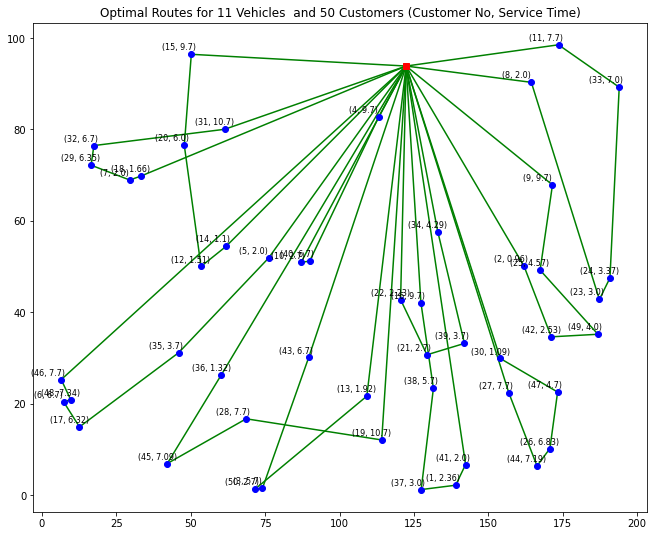

In [28]:
#For visualization
plt.figure(figsize=(11,9))
for i, j in active_arcs:
    plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')
for i in range(1,n+1):
    plt.text(koordinat[:,0:1][i]-10,koordinat[:,1:2][i]+1, liste1[i], fontsize = 8)
plt.title("Optimal Routes for "+ str(len(liste2))+ " Vehicles  and " + str(n)+ " Customers " + "(Customer No, Service Time)")
plt.show()

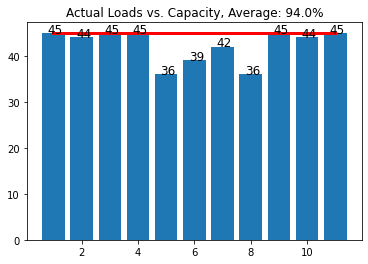

In [25]:
plt.plot (range(1,len(liste2)+1),[Q for i in range(len(liste2))], color = "r",linewidth=3)
plt.bar(range(1,len(liste2)+1), liste2)
for i in range(len(liste2)):
    plt.text(list(range(1,len(liste2)+1))[i]-0.2,liste2[i], liste2[i], fontsize = 12)
plt.title("Actual Loads vs. Capacity, Average: "+str(100*round(sum(q.values())/(len(liste2)*Q),2))+"%")
plt.show()

In [26]:
mdl.printAttr("X")


    Variable            X 
-------------------------
      x[0,2]            1 
      x[0,5]            1 
      x[0,8]            1 
     x[0,10]            1 
     x[0,13]            1 
     x[0,14]            1 
     x[0,18]            1 
     x[0,22]            1 
     x[0,30]            1 
     x[0,36]            1 
     x[0,41]            1 
     x[1,37]            1 
     x[2,42]            1 
     x[3,43]            1 
      x[4,0]            1 
     x[5,35]            1 
     x[6,48]            1 
     x[7,29]            1 
     x[8,23]            1 
      x[9,0]            1 
    x[10,40]            1 
     x[11,0]            1 
    x[12,20]            1 
    x[13,50]            1 
    x[14,12]            1 
     x[15,0]            1 
     x[16,0]            1 
     x[17,6]            1 
     x[18,7]            1 
     x[19,0]     0.999999 
    x[20,15]            1 
    x[21,39]     0.999999 
    x[22,21]            1 
    x[23,24]            1 
    x[24,33]            1 
 

In [27]:
#if model turns out to be infeasible, run this code and see why model is infeasible.
mdl.feasRelaxS(0, False,False,True)
mdl.optimize()
mdl.printAttr("X","Art*")

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5303 rows, 10605 columns and 28206 nonzeros
Model fingerprint: 0x68fedd5f
Variable types: 8055 continuous, 2550 integer (2550 binary)
Coefficient statistics:
  Matrix range     [3e-01, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-01, 1e+01]

MIP start from previous solve produced solution with objective 0 (0.07s)
Loaded MIP start from previous solve with objective 6.66134e-16


Explored 0 nodes (0 simplex iterations) in 0.07 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 6.66134e-16 

Optimal solution found (tolerance 5.00e-02)
Best objective 6.661338147751e-16, best bound 0.000000000000e+00, gap 0.0000%

    Variable            X 
-------------------------
